In [1]:
# set up model like in CampusAI/Hamiltonian-Generative-Networks

In [74]:
import ast
import argparse
import copy
import pprint
import os
import sys
import warnings
import yaml

import numpy as np
import torch
import tqdm

from utilities.integrator import Integrator
from utilities.training_logger import TrainingLogger
from utilities import loader
from utilities.loader import load_hgn, get_online_dataloaders, get_offline_dataloaders
from utilities.losses import reconstruction_loss, kld_loss, geco_constraint
from utilities.statistics import mean_confidence_interval
from train import _read_config, _merge_configs, _ask_confirmation, _overwrite_config_with_cmd_arguments, HgnTrainer

In [99]:
DEFAULT_TRAIN_CONFIG_FILE = "experiment_params/train_config_default.yaml"
DEFAULT_DATASET_CONFIG_FILE = "experiment_params/dataset_offline_default.yaml"
DEFAULT_ENVIRONMENTS_PATH = "experiment_params/default_environments/"
DEFAULT_SAVE_MODELS_DIR = "saved_models/"

parser = argparse.ArgumentParser()
parser.add_argument(
    '--train-config', action='store', nargs=1, type=str, required=True,
    help=f'Path to the training configuration yaml file.'
)
parser.add_argument(
    '--dataset-config', action='store', nargs=1, type=str, required=False,
    help=f'Path to the dataset configuration yaml file.'
)
parser.add_argument(
    '--name', action='store', nargs=1, required=False,
    help='If specified, this name will be used instead of experiment_id of the yaml file.'
)
parser.add_argument(
    '--epochs', action='store', nargs=1, type=int, required=False,
    help='The number of training epochs. If not specified, optimization.epochs of the '
         'training configuration will be used.'
)
parser.add_argument(
    '--env', action='store', nargs=1, type=str, required=False,
    help='The environment to use (for online training only). Possible values are '
         '\'pendulum\', \'spring\', \'two_bodies\', \'three_bodies\', corresponding to '
         'environment configurations in experiment_params/default_environments/. If not '
         'specified, the environment specified in the given --dataset-config will be used.'
)
parser.add_argument(
    '--dataset-path', action='store', nargs=1, type=str, required=False,
    help='Path to a stored dataset to use for training. For offline training only. In this '
         'case no dataset configuration file will be loaded.'
)
parser.add_argument(
    '--params', action='store', nargs='+', required=False,
    help='Override one or more parameters in the config. The format of an argument is '
         'param_name=param_value. Nested parameters are accessible by using a dot, '
         'i.e. --param dataset.img_size=32. IMPORTANT: lists must be enclosed in double '
         'quotes, i.e. --param environment.mass:"[0.5, 0.5]".'
)
parser.add_argument(
    '-y', '-y', action='store_true', default=False, required=False,
    help='Whether to skip asking for user confirmation before starting the training.'
)
parser.add_argument(
    '--resume', action='store', required=False, nargs='?', default=None,
    help='NOT IMPLEMENTED YET. Resume the training from a saved model. If a path is provided, '
         'the training will be resumed from the given checkpoint. Otherwise, the last '
         'checkpoint will be taken from saved_models/<experiment_id>.'
)
parser.add_argument(
    '--load', action='store', type=str, required=False, nargs=1,
    help='Path from which to load the HGN.'
)
parser.add_argument(
    '--reset', action='store', nargs='+', required=False,
    help='Use only in combimation with --load, tells the trainer to reinstantiate the given '
         'networks. Values: \'encoder\', \'transformer\', \'decoder\', \'hamiltonian\'.'
)

sys.argv = ['foo',
           '--train-config', DEFAULT_TRAIN_CONFIG_FILE,
           '--dataset-config', DEFAULT_DATASET_CONFIG_FILE,
           '-y']

_args = parser.parse_args()

# Read configurations
_train_config = _read_config(_args.train_config[0])
if _args.dataset_path is None:  # Will use the dataset config file (or default if not given)
    _dataset_config_file = DEFAULT_DATASET_CONFIG_FILE if _args.dataset_config is None else \
        _args.dataset_config[0]
    _dataset_config = _read_config(_dataset_config_file)
    _config = _merge_configs(_train_config, _dataset_config)
else:  # Will use the dataset given in the command line arguments
    assert _args.dataset_config is None, 'Both --dataset-path and --dataset-config were given.'
    _config = _train_config

# Overwrite configuration with command line arguments
_overwrite_config_with_cmd_arguments(_config, _args)

# Show configuration and ask user for confirmation
if not _args.y:
    _ask_confirmation(_config)

# Train HGN network
trainer = HgnTrainer(_config, resume=True)

Training with OFFLINE data...


In [100]:
_config['environment']

KeyError: 'environment'

In [101]:
# load hgn model, which were saved? can we look at all saved?

In [102]:
dataset_name = 'mass_spring_multi_colors'
save_path = '/data/ca15/hgn-pytorch/saved_models/'
load_path = save_path + dataset_name + '_checkpoint_10000'

In [103]:
params = {}

params['load_path'] = load_path
params['reset'] = []
params['device'] = trainer.device
params['dtype'] = trainer.dtype

In [104]:
trainer.load_and_reset(params, params['device'], params['dtype'])

In [105]:

# train_image = next(iter(trainer.test_data_loader))
train_image = trainer.test_data_loader.dataset[10]
train_image.shape


(34, 3, 32, 32)

(-0.5, 31.5, 31.5, -0.5)

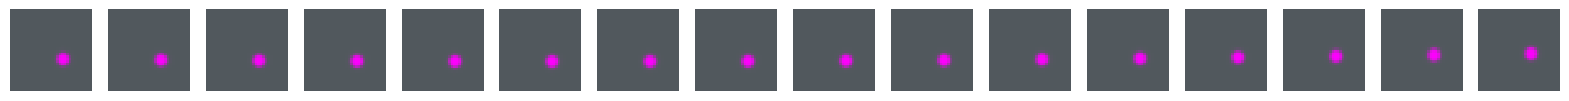

In [106]:

import matplotlib.pylab as plt

np_train_image = train_image.transpose(0,2,3,1)

plt.figure(figsize=(20,6))
plt.subplot(1,16,1)
plt.imshow(np_train_image[0])
plt.axis('off')
plt.subplot(1,16,2)
plt.imshow(np_train_image[1])
plt.axis('off')
plt.subplot(1,16,3)
plt.imshow(np_train_image[2])
plt.axis('off')
plt.subplot(1,16,4)
plt.imshow(np_train_image[3])
plt.axis('off')
plt.subplot(1,16,5)
plt.imshow(np_train_image[4])
plt.axis('off')
plt.subplot(1,16,6)
plt.imshow(np_train_image[5])
plt.axis('off')
plt.subplot(1,16,7)
plt.imshow(np_train_image[6])
plt.axis('off')
plt.subplot(1,16,8)
plt.imshow(np_train_image[7])
plt.axis('off')
plt.subplot(1,16,9)
plt.imshow(np_train_image[8])
plt.axis('off')
plt.subplot(1,16,10)
plt.imshow(np_train_image[9])
plt.axis('off')
plt.subplot(1,16,11)
plt.imshow(np_train_image[10])
plt.axis('off')
plt.subplot(1,16,12)
plt.imshow(np_train_image[11])
plt.axis('off')
plt.subplot(1,16,13)
plt.imshow(np_train_image[12])
plt.axis('off')
plt.subplot(1,16,14)
plt.imshow(np_train_image[13])
plt.axis('off')
plt.subplot(1,16,15)
plt.imshow(np_train_image[14])
plt.axis('off')
plt.subplot(1,16,16)
plt.imshow(np_train_image[15])
plt.axis('off')


In [107]:

train_image = torch.Tensor(train_image).unsqueeze(0).to(trainer.device).type(trainer.dtype)
train_image.shape


torch.Size([1, 34, 3, 32, 32])

In [108]:

rollout_len = train_image.shape[1]
input_frames = trainer.params['optimization']['input_frames']
n_frames = rollout_len - input_frames
print(rollout_len, input_frames, n_frames)


34 5 29


In [109]:

hgn_output = trainer.hgn.forward(rollout_batch=train_image[:, :input_frames], n_steps=n_frames)
prediction = hgn_output.reconstructed_rollout
prediction.shape


torch.Size([1, 30, 3, 32, 32])

In [110]:

np_prediction = prediction[0].permute(0,2,3,1).detach().cpu().numpy()
np_prediction.shape
np_prediction.min(), np_prediction.max()

(0.99957734, 1.0)

(-0.5, 31.5, 31.5, -0.5)

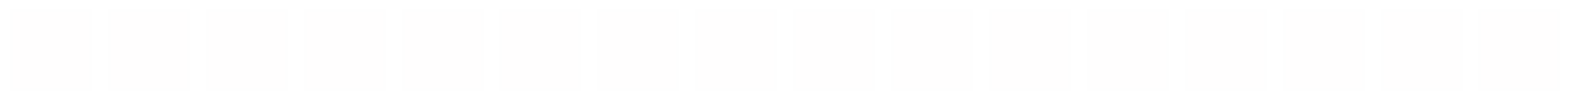

In [113]:

plt.figure(figsize=(20,6))
plt.subplot(1,16,1)
plt.imshow(np_prediction[0])
plt.axis('off')
plt.subplot(1,16,2)
plt.imshow(np_prediction[1])
plt.axis('off')
plt.subplot(1,16,3)
plt.imshow(np_prediction[2])
plt.axis('off')
plt.subplot(1,16,4)
plt.imshow(np_prediction[3])
plt.axis('off')
plt.subplot(1,16,5)
plt.imshow(np_prediction[4])
plt.axis('off')
plt.subplot(1,16,6)
plt.imshow(np_prediction[5])
plt.axis('off')
plt.subplot(1,16,7)
plt.imshow(np_prediction[6])
plt.axis('off')
plt.subplot(1,16,8)
plt.imshow(np_prediction[7])
plt.axis('off')
plt.subplot(1,16,9)
plt.imshow(np_prediction[8])
plt.axis('off')
plt.subplot(1,16,10)
plt.imshow(np_prediction[9])
plt.axis('off')
plt.subplot(1,16,11)
plt.imshow(np_prediction[10])
plt.axis('off')
plt.subplot(1,16,12)
plt.imshow(np_prediction[11])
plt.axis('off')
plt.subplot(1,16,13)
plt.imshow(np_prediction[12])
plt.axis('off')
plt.subplot(1,16,14)
plt.imshow(np_prediction[13])
plt.axis('off')
plt.subplot(1,16,15)
plt.imshow(np_prediction[14])
plt.axis('off')
plt.subplot(1,16,16)
plt.imshow(np_prediction[15])
plt.axis('off')


In [16]:
# save so that we can do fvd with other version of pytorch

In [17]:
data_dir = '/data/ca15/hgn-pytorch/'
generated_imgs_dir = data_dir + dataset_name + '/generated_imgs/'
input_frames = trainer.params['optimization']['input_frames']
# trainer.hgn = torch.nn.DataParallel(trainer.hgn, device_ids = [1, 2])
# trainer.hgn.to(trainer.device)
print(generated_imgs_dir)

/data/ca15/hgn-pytorch/three_body_colors/generated_imgs/


In [18]:
if not os.path.exists(generated_imgs_dir):
    os.makedirs(generated_imgs_dir)

In [ ]:
# get a random batch
dataloader = iter(trainer.test_data_loader)
n = int(2048 / 16 * 5)
for i in range(n):
    data = next(dataloader).to(trainer.device).type(trainer.dtype)
    # print(data.shape)
    hgn_output = trainer.hgn.forward(rollout_batch=data[:, :input_frames], n_steps=16, variational=False)
    prediction = hgn_output.reconstructed_rollout
    # print(prediction.shape)
    filename = str(i).zfill(4)
    # print(filename)
    np.save(generated_imgs_dir + filename, prediction[:, 1:].detach().cpu().numpy())

In [ ]:
# pendulum, mass_spring, double_pendulum, two_body, three_body